In [3]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import loompy
import shoji
import logging
from tqdm import tqdm
import sys
import os
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=20)


In [4]:
db = shoji.connect()
db

,Contents
refdb,"9 workspaces, 0 dimensions, 0 tensors"
samples,"1203 workspaces, 0 dimensions, 0 tensors"


In [5]:
db.samples

,Contents
FilbinData,"0 workspaces, 2 dimensions, 21 tensors"
SF11159,"0 workspaces, 2 dimensions, 28 tensors"
SF11209,"0 workspaces, 2 dimensions, 28 tensors"
SF11215,"0 workspaces, 2 dimensions, 28 tensors"
SF11232,"0 workspaces, 2 dimensions, 28 tensors"
SF11247,"0 workspaces, 2 dimensions, 28 tensors"
SF11285,"0 workspaces, 2 dimensions, 28 tensors"
TenX01_1,"0 workspaces, 2 dimensions, 34 tensors"
TenX02_1,"0 workspaces, 2 dimensions, 34 tensors"
TenX04_1,"0 workspaces, 2 dimensions, 34 tensors"


# Load all samples into a workspace

In [3]:
del db.samples
db.samples = shoji.Workspace()
d = "/Users/stelin/samples/"
for f in tqdm(os.listdir(d)):
    if not f.endswith(".loom"):
        continue
    name = f[:-5]
    if f.startswith("10X") or f.startswith("10x"):
        name = "TenX" + name[3:]
    db.samples[name] = shoji.Workspace()
    db.samples[name]._from_loom(d + f, fix_expression_dtype=True)

100%|██████████| 1207/1207 [14:56:45<00:00, 44.58s/it]  


In [ ]:
# Load reference data into workspaces
db.refdb = shoji.Workspace()
db.refdb.mouse = shoji.Workspace()
db.refdb.mouse.development = shoji.Workspace()
db.refdb.mouse.development_agg = shoji.Workspace()
db.refdb.mouse.adult = shoji.Workspace()
db.refdb.mouse.adult_agg = shoji.Workspace()
db.refdb.human = shoji.Workspace()
db.refdb.human.development = shoji.Workspace()
db.refdb.human.development_agg = shoji.Workspace()
db.refdb.human.adult = shoji.Workspace()
db.refdb.human.adult_agg = shoji.Workspace()

In [3]:
db.samples.TenX201_1

,Contents
human,"0 workspaces, 0 dimensions, 0 tensors"
human_adult,"0 workspaces, 0 dimensions, 0 tensors"
human_adult_agg,"0 workspaces, 2 dimensions, 416 tensors"
human_development,"0 workspaces, 0 dimensions, 0 tensors"
human_development_agg,"0 workspaces, 2 dimensions, 376 tensors"
mouse_adolescent,"0 workspaces, 2 dimensions, 137 tensors"
mouse_adolescent_agg,"0 workspaces, 2 dimensions, 229 tensors"
mouse_development,"0 workspaces, 2 dimensions, 74 tensors"
mouse_development_agg,"0 workspaces, 2 dimensions, 154 tensors"


In [4]:
db.refdb.human_development._from_loom("/Users/stelin/cytograph/20200702_human_dev/data/Allbrain.loom", fix_expression_dtype=True)

2020-10-04 23:11:35,273 - INFO - GeneSummaryStatistics: Computing summary statistics for genes
2020-10-04 23:11:40,361 - INFO - GeneSummaryStatistics: Done.
2020-10-04 23:11:40,368 - INFO - SummaryStatistics: Saving mean expression per gene as float32 tensor 'MeanExpression'
2020-10-04 23:11:40,369 - INFO - SummaryStatistics: Saving standard deviation per gene as float32 tensor 'StdevExpression'
2020-10-04 23:11:41,920 - INFO - DoubletFinder: Creating artificial doublets
2020-10-04 23:12:01,100 - INFO - DoubletFinder: Feature selection and dimensionality reduction
2020-10-04 23:12:01,108 - INFO - FeatureSelectionByVariance: Fitting CV vs mean
2020-10-04 23:12:12,699 - INFO - FeatureSelectionByVariance: Done.
2020-10-04 23:12:18,002 - INFO - DoubletFinder: Initializing NN structure with k = 60
2020-10-04 23:12:19,236 - INFO - DoubletFinder: Finding the doublet score threshold
2020-10-04 23:12:21,794 - INFO - DoubletFinder: Finding doublet neighbors
2020-10-04 23:12:21,820 - INFO - Doubl

(-88.63347816467285, 100.74948310852051, -92.30757637023926, 92.74987525939942)

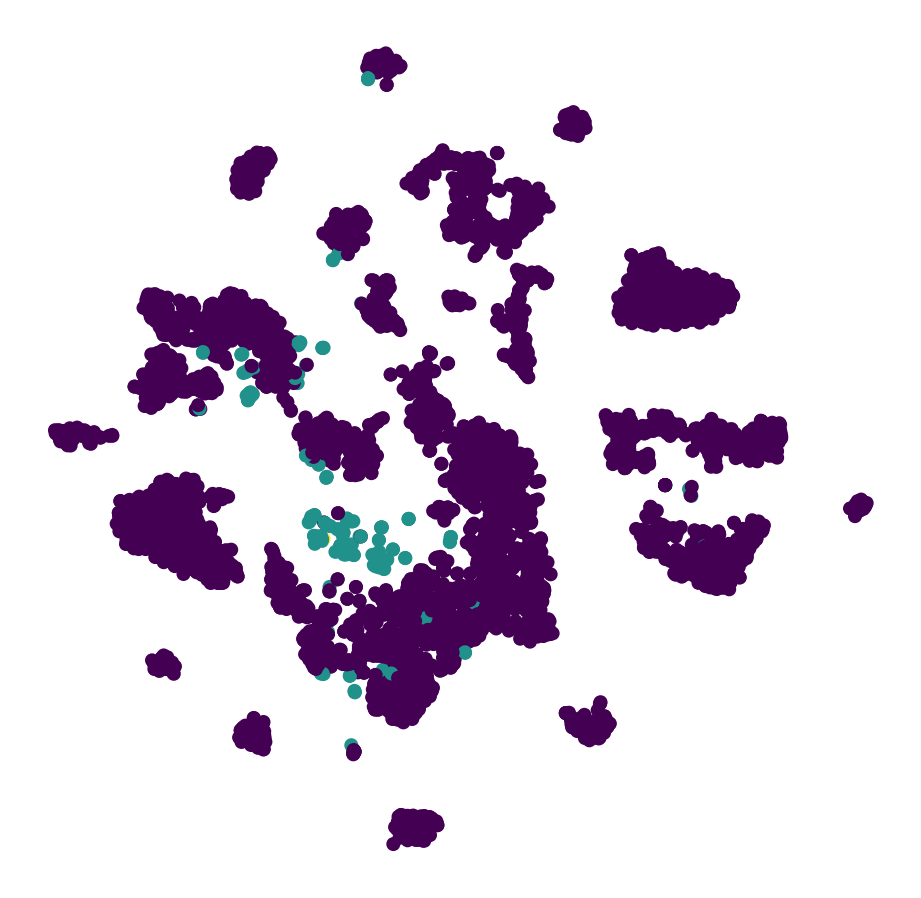

In [4]:
mu, sd = cg.GeneSummaryStatistics().fit_save(ws)
score, flag = cg.DoubletFinder().fit_save(ws)
plt.figure(figsize=(8,8))
plt.scatter(ws.TSNE[:][:, 0], ws.TSNE[:][:,1], c=flag)
plt.axis("off")

In [5]:
cg.CellSummaryStatistics(cg.human).fit_save(ws)

2020-10-04 23:13:15,562 - INFO - SummaryStatistics: Loading 'Expression' and 'Unspliced' tensors
2020-10-04 23:13:24,883 - INFO - SummaryStatistics: Computing summary statistics for cells
2020-10-04 23:13:25,398 - INFO - SummaryStatistics: Average number of non-zero genes 4756
2020-10-04 23:13:25,398 - INFO - SummaryStatistics: Average total UMIs 15865
2020-10-04 23:13:25,399 - INFO - SummaryStatistics: Average mitochondrial UMI fraction 0.39%
2020-10-04 23:13:25,399 - INFO - SummaryStatistics: Average unspliced fraction 74.01%
2020-10-04 23:13:25,399 - INFO - SummaryStatistics: Average cell cycle UMI fraction 0.11%
2020-10-04 23:13:25,479 - INFO - SummaryStatistics: Saving nnz as uint32 tensor 'NGenes'
2020-10-04 23:13:25,479 - INFO - SummaryStatistics: Saving n_UMIs as uint32 tensor 'TotalUMIs'
2020-10-04 23:13:25,480 - INFO - SummaryStatistics: Saving mitochondrial UMI fraction as float32 tensor 'MitoFraction'
2020-10-04 23:13:25,480 - INFO - SummaryStatistics: Saving unspliced frac

(array([1636, 4424, 5197, ..., 5080, 4235, 1446]),
 array([ 3770., 12644., 15072., ..., 14922., 10426.,  2246.], dtype=float32),
 array([0.        , 0.00126542, 0.00019904, ..., 0.00053612, 0.01304431,
        0.00133571], dtype=float32),
 array([0.76472149, 0.76376147, 0.75218949, ..., 0.75023455, 0.68012661,
        0.71193232]),
 array([0.00185676, 0.00166087, 0.00072983, ..., 0.00067015, 0.00124688,
        0.00133571], dtype=float32))

<ipython-input-28-40977a8292ad>:1: RuntimeWarning: invalid value encountered in true_divide
  plt.scatter(ws[:].MeanExpression, ws[:].StdevExpression / ws[:].MeanExpression, s=5)


(0.1, 100)

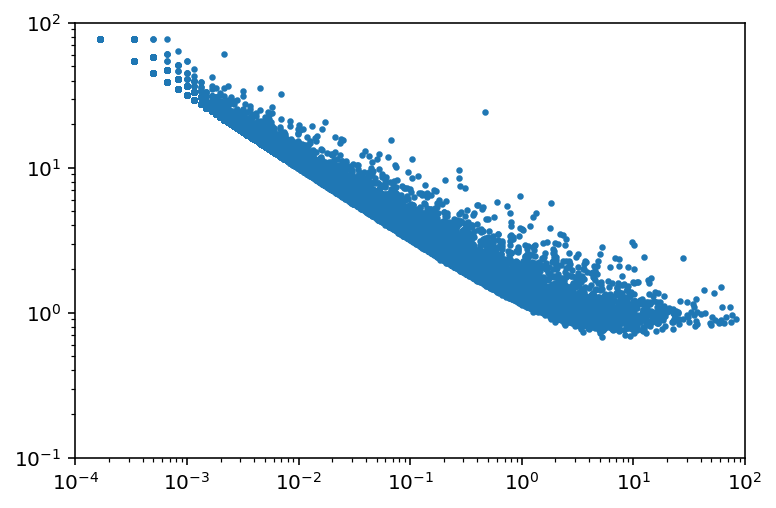

In [28]:
plt.scatter(ws[:].MeanExpression, ws[:].StdevExpression / ws[:].MeanExpression, s=5)
plt.yscale("log")
plt.xscale("log")
plt.xlim(.0001,100)
plt.ylim(0.1,100)

In [20]:
gb = ws.cells.groupby("Clusters")

In [22]:
gb.mean("TotalUMI")

(array([ 3,  6,  0,  5,  7,  8,  4, 10, 13,  1,  2,  9, 11, 12]),
 array([16417.93045113, 16205.75110132, 15594.41492537, 16103.18358531,
        15546.26405868, 14513.13612565, 16826.64049587, 16860.21981424,
        15782.61538462, 16099.84304207, 15760.92363636, 15205.0183727 ,
        15643.89735099, 14946.6292517 ]))

In [24]:
gb = ws[ws.Clusters == 1].groupby("PassedQC_UnsplicedRatio")

In [25]:
gb.mean("TotalUMI")

(array([1, 0], dtype=uint8), array([16173.46829268,  1006.66666667]))

In [32]:
gb.count.__self__.__class__

shoji.groupby.GroupViewBy

In [194]:
from typing import *
import functools

class ResultHolder:
    def __init__(self, args, stored) -> None:
        self.args = args
        self.stored = stored
    
def creates(name: str, dtype: str, dims: Tuple[Optional[Union[str, int]], ...]) -> Callable:
    """
    Declare the tensors that are created by a Cytograph fit() method, when save=True

    Usage:
        class Test:
            @creates("Expression", "float32", ("cells", "genes"))
            @creates("Age", "string", ())
            def fit(self, ws, save) -> None:
                # body of method
                return (expression, age)  # Note order must match order of decorators
                # If fit() was called with save=True, the return values will be saved as the indicated tensors

    Remarks:
        The decorator can only be applied to a method that takes a shoji.WorkspaceManager object as first argument
    """
    def decorator(func: Callable) -> Callable:
        @functools.wraps(func)
        def wrapper(self, ws: shoji.WorkspaceManager, *args, **kwargs):
            result = func(self, ws, *args, **kwargs)
            if "save" not in kwargs or not kwargs["save"]:
                return result
            if not isinstance(result, ResultHolder):
                result = ResultHolder(result, result)
            ws[name] = shoji.Tensor(dtype, dims, inits=result.args[-1])
            if len(result.args) == 1:
                return result.stored
            return ResultHolder(result.args[:-1], result.stored)
        return wrapper
    return decorator


In [198]:
class Test:
    @requires("Expression", "float32", ("cells", "genes"))
    @requires("Age", "string", ())
    @creates("Test", "uint8", ("genes",))
    @creates("Test2", "uint8", ("genes",))
    def fit(ws, self, arg1, arg2, save=False) -> None:
        return np.zeros(33538, dtype="uint8"), np.ones(33538, dtype="uint8")

In [199]:
t = Test()

In [200]:
t.fit(ws, 1, 2, save=True)

(array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 array([1, 1, 1, ..., 1, 1, 1], dtype=uint8))

In [172]:
ws

Workspace with 0 workspaces, 2 dimensions and 61 tensors:
  cells <Dimension of variable shape>
  genes <Dimension of shape 33538>
  Accession <Tensor Accession dtype='string' dims=('genes',), shape=(33538,)>
  Age <Tensor Age dtype='string' dims=(), shape=()>
  Ambiguous <Tensor Ambiguous dtype='uint16' dims=('cells', 'genes'), shape=(6031, 33538)>
  BpLength <Tensor BpLength dtype='int64' dims=(), shape=()>
  CDNAConc <Tensor CDNAConc dtype='float64' dims=(), shape=()>
  CellConc <Tensor CellConc dtype='int64' dims=(), shape=()>
  CellCycle <Tensor CellCycle dtype='float64' dims=('cells',), shape=(6031,)>
  CellCycleFraction <Tensor CellCycleFraction dtype='float32' dims=('cells',), shape=(6031,)>
  CellCycle_G1 <Tensor CellCycle_G1 dtype='float64' dims=('cells',), shape=(6031,)>
  CellCycle_G2M <Tensor CellCycle_G2M dtype='float64' dims=('cells',), shape=(6031,)>
  CellCycle_S <Tensor CellCycle_S dtype='float64' dims=('cells',), shape=(6031,)>
  CellID <Tensor CellID dtype='string' dims=('cells',), shape=(6031,)>
  Chemistry <Tensor Chemistry dtype='string' dims=(), shape=()>
  Chromosome <Tensor Chromosome dtype='string' dims=('genes',), shape=(33538,)>
  Clusters <Tensor Clusters dtype='int64' dims=('cells',), shape=(6031,)>
  Comment <Tensor Comment dtype='string' dims=(), shape=()>
  CreationDate <Tensor CreationDate dtype='string' dims=(), shape=()>
  Donor <Tensor Donor dtype='string' dims=(), shape=()>
  DoubletFinderFlag <Tensor DoubletFinderFlag dtype='int64' dims=('cells',), shape=(6031,)>
  DoubletFinderScore <Tensor DoubletFinderScore dtype='float64' dims=('cells',), shape=(6031,)>
  DoubletFlag <Tensor DoubletFlag dtype='uint8' dims=('cells',), shape=(6031,)>
  DoubletScore <Tensor DoubletScore dtype='float32' dims=('cells',), shape=(6031,)>
  End <Tensor End dtype='int64' dims=('genes',), shape=(33538,)>
  Expression <Tensor Expression dtype='float32' dims=('cells', 'genes'), shape=(6031, 33538)>
  FinalConc <Tensor FinalConc dtype='float64' dims=(), shape=()>
  Gene <Tensor Gene dtype='string' dims=('genes',), shape=(33538,)>
  IsCycling <Tensor IsCycling dtype='uint8' dims=('cells',), shape=(6031,)>
  LOOM_SPEC_VERSION <Tensor LOOM_SPEC_VERSION dtype='string' dims=(), shape=()>
  MT_ratio <Tensor MT_ratio dtype='float64' dims=('cells',), shape=(6031,)>
  MeanExpression <Tensor MeanExpression dtype='float32' dims=('genes',), shape=(33538,)>
  MeanTotalUMI <Tensor MeanTotalUMI dtype='float64' dims=(), shape=()>
  MitoFraction <Tensor MitoFraction dtype='float32' dims=('cells',), shape=(6031,)>
  NGenes <Tensor NGenes dtype='uint32' dims=('cells',), shape=(6031,)>
  PCA <Tensor PCA dtype='float32' dims=('cells', 50), shape=(6031, 50)>
  PCRCycles <Tensor PCRCycles dtype='int64' dims=(), shape=()>
  PassedQC <Tensor PassedQC dtype='uint8' dims=('cells',), shape=(6031,)>
  PassedQC_MT_ratio <Tensor PassedQC_MT_ratio dtype='uint8' dims=('cells',), shape=(6031,)>
  PassedQC_TotalUMI <Tensor PassedQC_TotalUMI dtype='uint8' dims=('cells',), shape=(6031,)>
  PassedQC_UMIPerGene <Tensor PassedQC_UMIPerGene dtype='uint8' dims=('cells',), shape=(6031,)>
  PassedQC_UnsplicedRatio <Tensor PassedQC_UnsplicedRatio dtype='uint8' dims=('cells',), shape=(6031,)>
  PassedQC_gobal <Tensor PassedQC_gobal dtype='uint8' dims=(), shape=()>
  RegionOfInterest <Tensor RegionOfInterest dtype='string' dims=(), shape=()>
  SampleName <Tensor SampleName dtype='string' dims=(), shape=()>
  Sex <Tensor Sex dtype='string' dims=(), shape=()>
  Species <Tensor Species dtype='string' dims=(), shape=()>
  Spliced <Tensor Spliced dtype='uint16' dims=('cells', 'genes'), shape=(6031, 33538)>
  Start <Tensor Start dtype='int64' dims=('genes',), shape=(33538,)>
  StdevExpression <Tensor StdevExpression dtype='float32' dims=('genes',), shape=(33538,)>
  Strand <Tensor Strand dtype='string' dims=('genes',), shape=(33538,)>
  TSNE <Tensor TSNE dtype='float32' dims=('cells', 2), shape=(6031, 2)>
  TargetNumCells <Tensor TargetNumCells dtype='int64' dims=(